In [25]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import normalize, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.decomposition import KernelPCA, SparsePCA, TruncatedSVD, PCA
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import MDS


In [26]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [27]:
ds = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')
ds

,package_name,review,date,star
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...,October 12 2016,4
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...,August 23 2016,4
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...,August 04 2016,5
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...,July 25 2016,3
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...,July 22 2016,5
...,...,...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...,June 24 2016,3
288061,com.termux.api,I like this app . Its is very helpful for use....,June 20 2016,5
288062,com.termux.api,Finally Brings back the Unix command line to A...,May 20 2016,5
288063,com.termux.api,The API feature is great just need loads more...,May 05 2016,5


In [28]:
list_ = []  
for i in range(len(ds['package_name'].unique())):
    ds_aux = ds.loc[ds['package_name'] == ds['package_name'].unique()[i]]
    #rescatamos en list_ los packages names unicos de todo el dataset
    list_.append({'package_name':ds['package_name'].unique()[i], 'size': len(ds_aux)})

#ordenamos de acuerdo al numero de datos de cada package name (de mayor a menor)
list_ = sorted(list_, key=lambda x: x['size'], reverse=True)

#seleccionamos el package name # 40 y almacenamos los reviews en el corpus
df = ds[ds['package_name'] == list_[8]['package_name']]
corpus = list(df['review'])

corpus_ds = {
    'Sentences' : corpus
}

ds_new = pd.DataFrame(corpus_ds)
print(ds_new)

                                              Sentences
0                                 Authentication Morris
1     I can't access my account We couldn't verify y...
2     This app works fine Later found the secret key...
3                                     very good love it
4       Powerful app Awesome app to safe my transaction
...                                                 ...
2971                              I'm feeling very well
2972              Doesn't work  can't add any accounts.
2973  Only one concern but not sure if it was the ap...
2974                                           Verygood
2975  This is very bad and not change password and v...

[2976 rows x 1 columns]


In [29]:
corpus_embeddings = embedder.encode(corpus)
corpus_embeddings = normalize(corpus_embeddings)

In [30]:
corpus_embeddings

array([[-0.07346874,  0.04389574, -0.06648979, ...,  0.01977391,
        -0.00062523, -0.0152824 ],
       [-0.01260134, -0.00919266, -0.01179603, ...,  0.07379184,
        -0.01578063, -0.06204431],
       [-0.12520783, -0.05089017, -0.02154951, ...,  0.03187095,
        -0.04763262,  0.06186906],
       ...,
       [-0.08462875,  0.02994278,  0.05305524, ..., -0.04237437,
        -0.05856031,  0.03175796],
       [-0.0875682 , -0.00778797, -0.00966952, ...,  0.12993482,
        -0.00096668,  0.04250968],
       [-0.05208034,  0.01569614, -0.06941363, ...,  0.0624142 ,
         0.03035553, -0.00782692]], dtype=float32)

In [31]:
corpus_embeddings.shape

(2976, 384)

In [23]:
scaler = PCA(n_components=2, random_state = 100)
X_principal = scaler.fit_transform(corpus_embeddings)


In [24]:
X_principal.shape

(2976, 2)

In [11]:
X_principal

array([[ 0.03437291, -0.03180677],
       [-0.32140195, -0.28879294],
       [-0.3759647 ,  0.06703991],
       ...,
       [-0.28515172, -0.04459459],
       [ 0.49017856,  0.13501269],
       [-0.1624418 , -0.10337018]], dtype=float32)

In [12]:
distribution = pd.DataFrame(X_principal, columns=['x', 'y'])
distribution

,x,y
0,0.034373,-0.031807
1,-0.321402,-0.288793
2,-0.375965,0.067040
3,0.498591,0.094174
4,-0.216111,0.278162
...,...,...
2971,0.357641,-0.028137
2972,-0.184143,-0.281847
2973,-0.285152,-0.044595
2974,0.490179,0.135013


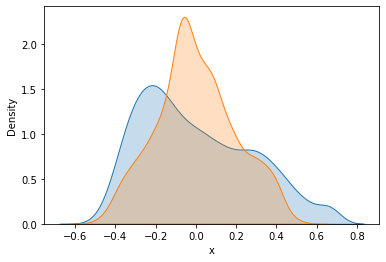

In [13]:
for col in 'xy':
    sns.kdeplot(distribution[col], shade=True)

C:\Users\marit\AppData\Roaming\Python\Python310\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


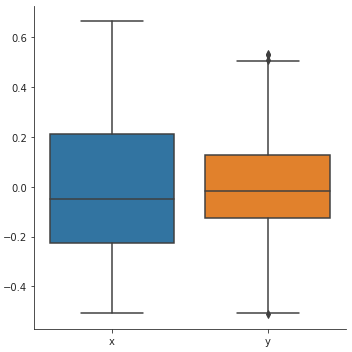

In [14]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot(data=distribution, kind="box")

In [15]:
def best_cluster_agglomerative(j):
    best_k = 0
    best_average = 0
    best_cluster = []
    for k in range(2,j):

        agglomerative_clusterering = AgglomerativeClustering(n_clusters=k, affinity="cosine" , linkage='complete')
        agglomerative_clusterering.fit(X_principal)
        cluster_labels = agglomerative_clusterering.labels_
        distances = agglomerative_clusterering.children_
        best_cluster.append(cluster_labels)

        silhouette_avg = silhouette_score(X_principal, cluster_labels)
        print("cluster: ",k)
        print("silhouette_avg: ",silhouette_avg)
        print(cluster_labels)
        print(distances)
        print("\n")
    
        if(silhouette_avg > best_average):
            best_average = silhouette_avg
            best_k = k

    return best_k, best_average, best_cluster[best_k-2]

In [21]:
best_k_HC, best_average_HC, best_cluster = best_cluster_agglomerative(20)
print(best_k_HC)
print(best_average_HC)
print(best_cluster)

cluster:  2
silhouette_avg:  0.4019685
[0 1 1 ... 1 0 1]
[[1651 1749]
 [2157 2976]
 [2530 2977]
 ...
 [5944 5946]
 [5945 5947]
 [5948 5949]]


cluster:  3
silhouette_avg:  0.28204638
[2 0 0 ... 0 1 0]
[[1651 1749]
 [2157 2976]
 [2530 2977]
 ...
 [5944 5946]
 [5945 5947]
 [5948 5949]]


cluster:  4
silhouette_avg:  0.30861402
[2 1 1 ... 1 0 1]
[[1651 1749]
 [2157 2976]
 [2530 2977]
 ...
 [5944 5946]
 [5945 5947]
 [5948 5949]]


cluster:  5
silhouette_avg:  0.28222278
[2 0 0 ... 0 3 0]
[[1651 1749]
 [2157 2976]
 [2530 2977]
 ...
 [5944 5946]
 [5945 5947]
 [5948 5949]]


cluster:  6
silhouette_avg:  0.26196855
[0 2 5 ... 2 3 2]
[[1651 1749]
 [2157 2976]
 [2530 2977]
 ...
 [5944 5946]
 [5945 5947]
 [5948 5949]]


cluster:  7
silhouette_avg:  0.20626622
[6 2 5 ... 2 1 2]
[[1651 1749]
 [2157 2976]
 [2530 2977]
 ...
 [5944 5946]
 [5945 5947]
 [5948 5949]]


cluster:  8
silhouette_avg:  0.19902125
[6 0 5 ... 0 1 0]
[[1651 1749]
 [2157 2976]
 [2530 2977]
 ...
 [5944 5946]
 [5945 5947]
 [5948 59

In [17]:
clustering_model = AgglomerativeClustering(n_clusters=best_k_HC, affinity="cosine" , linkage='complete') #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(X_principal)
cluster_assignment = clustering_model.labels_
ds_new['clusters'] = cluster_assignment
print(cluster_assignment)

[0 1 1 ... 1 0 1]


In [18]:
ds_new = ds_new.sort_values(by=['clusters','Sentences'])
ds_new = ds_new.reset_index(drop=True)
ds_new

,Sentences,clusters
0,"""""This country is not allowed error""""""""""""""""""""""...",0
1,"""""cannot interpret QR code.""""""""""""""""""""""""""""""""""""",0
2,#VimpeloContente,0
3,&gt;:( !!!!!!!!!!!!! YOU NEED A COMPUTER!!!!!!...,0
4,&lt;3 it,0
...,...,...
2971,wtf clock set to auto sync from internet but ...,1
2972,wtf barcode reader ? it's hard to scan why you...,1
2973,you cant have enough security . ithink it woul...,1
2974,Установил Google Authenticator на телефон свя...,1


In [19]:
count = 0
for i in ds_new['Sentences'][ds_new['clusters'] == 0]:
    print(count , i ,end="\n")
    count+=1

0 ""This country is not allowed error"""""""""""""""" when setting up the backup email.""
1 ""cannot interpret QR code.""""""""""""""""""
2 #VimpeloContente
3 &gt;:( !!!!!!!!!!!!! YOU NEED A COMPUTER!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!???????????????????????
4 &lt;3 it
5 1 eg.Use.Usegoody 5★
6 2 good
7 2 steps verification . I like it .
8 2F Does the job nicely.
9 4 Stars Secure
10 5 Ok
11 5 star ! When it will be avaliable for desktop too?
12 50:50 Love the idea when it works. Sometimes doesn't work!!
13 6 diget code never works no help
14 A good
15 A must have... Anything I can slap a random # generator on  they rock for keeping snoops out of your stuff even with the pw...
16 A widget would make it perfect
17 A7 Esy
18 AH I would say soo and soo
19 AWESOME!
20 Aaaaa خیلی خوبه ولی هیف که رمز اول رو نمیده واسه اونایی که جیمیلشون هک شده
21 Aaaaaaaaaawwwwwwwwwwsssssssssssssooooooooooooooommmmmmmmmmmmme Good let's u sign in easier
22 Abao Love it
23 Abbas Loved. It
24 Abd للب
25 Absolute garb

             x         y  labels
0     0.034373 -0.031807       0
1    -0.321402 -0.288793       1
2    -0.375965  0.067040       1
3     0.498591  0.094174       0
4    -0.216111  0.278162       1
...        ...       ...     ...
2971  0.357641 -0.028137       0
2972 -0.184143 -0.281847       1
2973 -0.285152 -0.044595       1
2974  0.490179  0.135013       0
2975 -0.162442 -0.103370       1

[2976 rows x 3 columns]


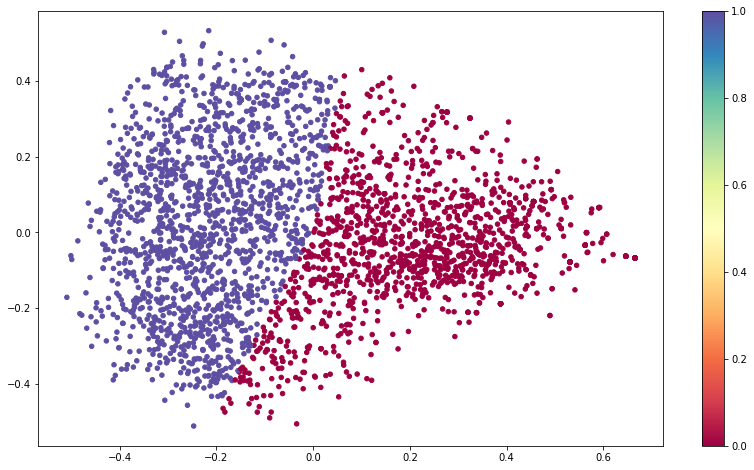

In [20]:
point_size = 100.0 / np.sqrt(corpus_embeddings.shape[0])

result = pd.DataFrame(X_principal, columns=['x', 'y'])
result['labels'] = clustering_model.labels_
print(result)

fig, ax = plt.subplots(figsize=(14, 8))
clustered = result[result.labels != -1]
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=20, cmap='Spectral')
plt.colorbar()
plt.show()